# TEST MEDIA PIPE ON BVS

In [1]:
from utils.load_config import load_config
from utils.load_data import load_data
from plots_utils.plot_BVS import display_image
from plots_utils.plot_BVS import display_images

import numpy as np
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

### load data

In [3]:
# define configuration
config_path = 'NR_08a_BFS_MediaPipe_lmks_m0001.json'

# load config
config = load_config(config_path, path='../../configs/norm_reference')

# load all ref frames
config['train_avatar'] = "all_identities"
config['train_expression'] = ["Neutral"]
ref_data = load_data(config, get_raw=True)
# load all expressions on louise
config['train_avatar'] = "Louise"
config['train_expression'] = ["all_expressions"]  # don't load the neutral expression (!= 'full') since it's already in ref_data
louise_expr_data = load_data(config, get_raw=True)

print("[LOAD] shape ref_data", np.shape(ref_data[0]))
print("[LOAD] shape louise_expr_data", np.shape(louise_expr_data[0]))
train_data = [np.vstack((ref_data[0], louise_expr_data[0])), np.concatenate((ref_data[1], louise_expr_data[1]))]
print("[LOAD] shape train_data[0]", np.shape(train_data[0]))
print("[LOAD] shape train_data[1]", np.shape(train_data[1]))
n_training = len(train_data[0])
print("[LOAD] n_training data", n_training)

100%|██████████| 6/6 [00:00<00:00, 54.97it/s]


[LOAD] shape ref_data (15, 720, 720, 3)
[LOAD] shape louise_expr_data (6, 720, 720, 3)
[LOAD] shape train_data[0] (21, 720, 720, 3)
[LOAD] shape train_data[1] (21,)
[LOAD] n_training data 21


In [ ]:
# For static images:
annotated_images = []
landmarks = []
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5) as face_mesh:
  for idx, img in enumerate(train_data[0]):
    # convert numpy to fit pipeline as uint8
    image = np.array(img).astype(np.uint8)

    # Convert the BGR image to RGB before processing.
    # results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    results = face_mesh.process(image)

    # Print and draw face mesh landmarks on the image.
    if not results.multi_face_landmarks:
      continue
    annotated_image = image.copy()
    for face_landmarks in results.multi_face_landmarks:
      print('face_landmarks:', face_landmarks)
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_TESSELATION,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_tesselation_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_CONTOURS,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_contours_style())
      mp_drawing.draw_landmarks(
          image=annotated_image,
          landmark_list=face_landmarks,
          connections=mp_face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp_drawing_styles
          .get_default_face_mesh_iris_connections_style())
    # cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)
    annotated_images.append(annotated_image)
    landmarks.append(face_landmarks)


In [17]:
print("len annotated_images", len(annotated_images))
print("shape annotated_images", np.shape(annotated_images))
print("shape landmarks", np.shape(landmarks))

len annotated_images 21
shape annotated_images (21, 720, 720, 3)
shape landmarks (21,)


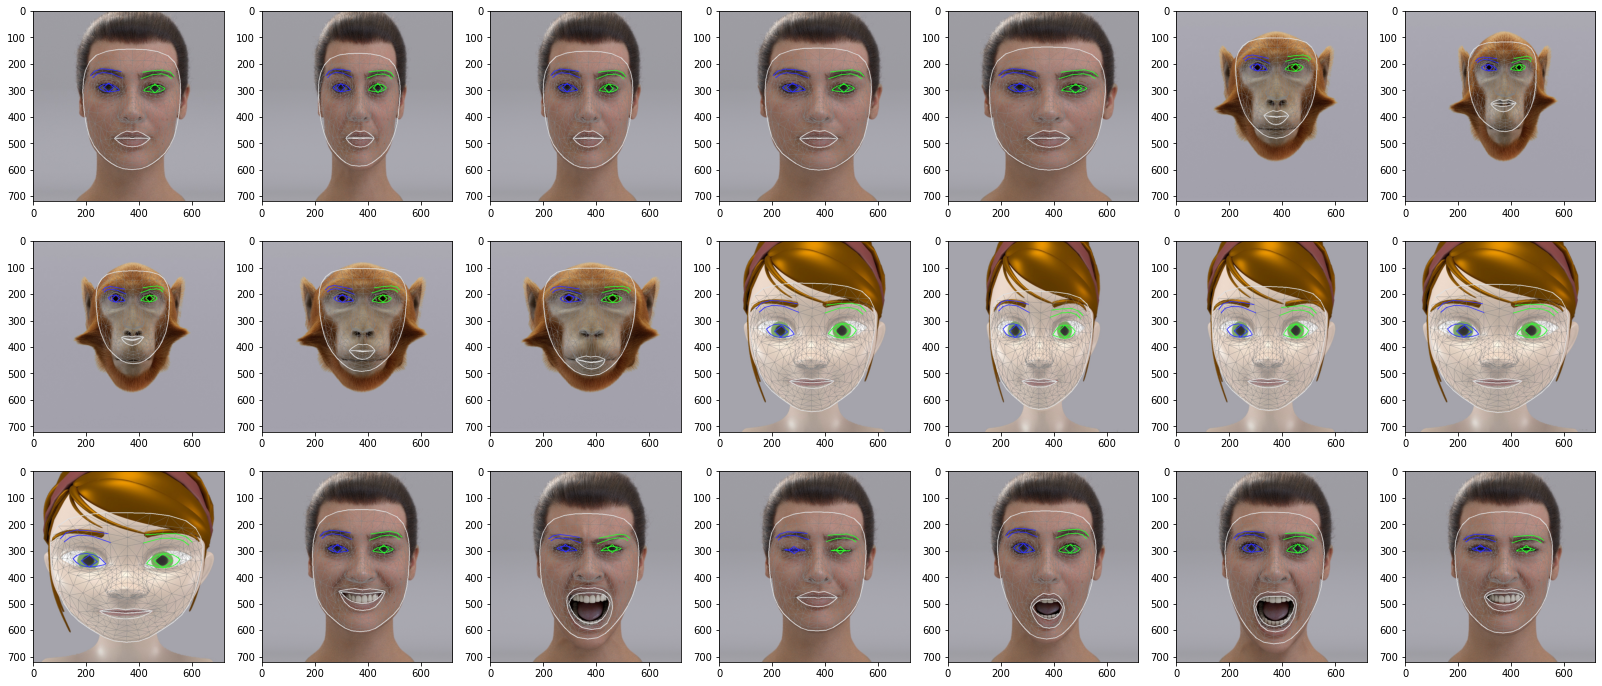

In [15]:
display_images(annotated_images)

# Train Norm-reference encoding on BFS using MediaPipe landmarks as input

In [17]:
print("shape ref_lmks_pos", np.shape(ref_lmks_pos))
print("shape expr_lmks_pos", np.shape(expr_lmks_pos))
n_features = np.shape(ref_lmks_pos)[1] * np.shape(ref_lmks_pos)[2]
print("n_features:", n_features)

shape ref_lmks_pos (15, 68, 2)
shape expr_lmks_pos (7, 68, 2)
n_features: 136


In [ ]:
# display predicted lmks
display_images(ref_training_data[0], lmks=ref_lmks_pos, n_max_col=5)
display_images(expr_training_data[0], lmks=expr_lmks_pos)

In [19]:
# # create subset of lmks
# sub_lmks = ref_lmks_pos[0]
# print("shape sub_lmks", np.shape(sub_lmks))
# # sub_lmks = [sub_lmks[17, :]]  # left-eyebrow ext
# # sub_lmks = [sub_lmks[21, :]]  # left-eyebrow int
# # sub_lmks = [sub_lmks[22, :]]  # right-eyebrow int
# # sub_lmks = [sub_lmks[26, :]]  # right-eyebrow ext
# # sub_lmks = [sub_lmks[41, :]]  # under left_eye
# # sub_lmks = [sub_lmks[46, :]]  # under right_eye
# # sub_lmks = [sub_lmks[48, :]]  # left mouth corner
# # sub_lmks = [sub_lmks[51, :]]  # top mouth
# # sub_lmks = [sub_lmks[54, :]]  # right mouth corner
# # sub_lmks = [sub_lmks[57, :]]  # lower mouth
# print("shape sub_lmks", np.shape(sub_lmks))
# print("shape ref_traininf_data[0]", np.shape(ref_training_data[0]))
# display_images([ref_training_data[0][0]], lmks=[sub_lmks], size_img=6)

shape sub_ref_lmks_pos (15, 10, 2)
shape sub_expr_lmks_pos (7, 10, 2)


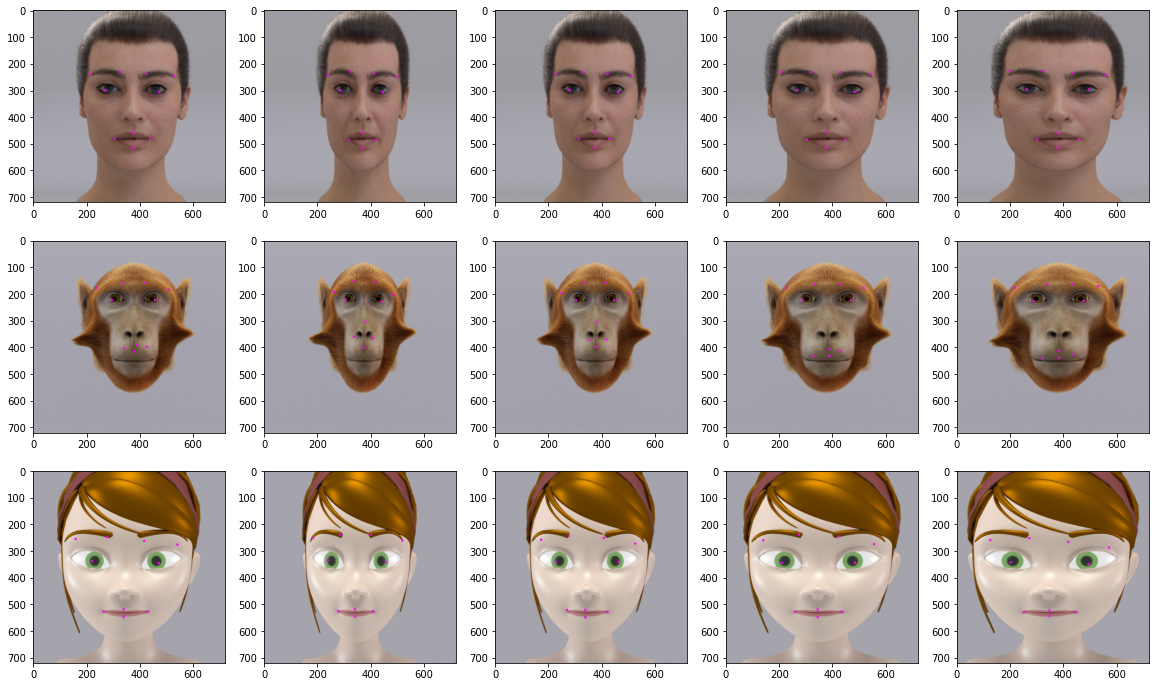

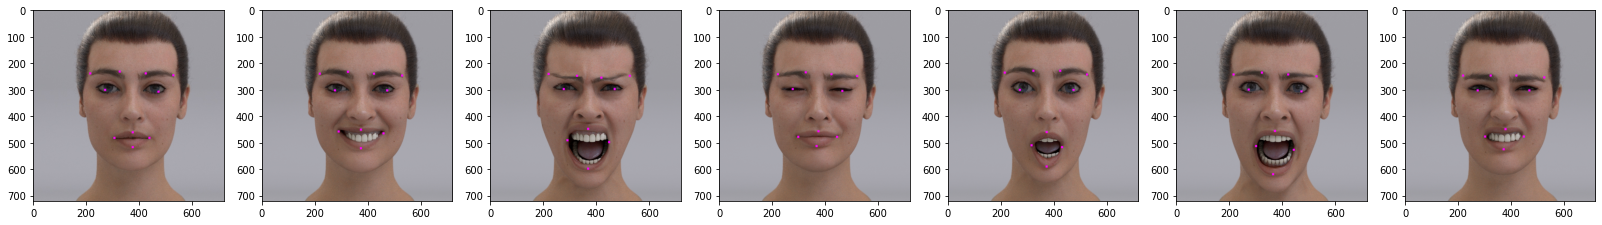

In [20]:
sub_idx = [17, 21, 22, 26, 48, 51, 54, 57, 41, 46]
sub_ref_lmks_pos = ref_lmks_pos[:, sub_idx, :]
sub_expr_lmks_pos = expr_lmks_pos[:, sub_idx, :]
print("shape sub_ref_lmks_pos", np.shape(sub_ref_lmks_pos))
print("shape sub_expr_lmks_pos", np.shape(sub_expr_lmks_pos))
display_images(ref_training_data[0], lmks=sub_ref_lmks_pos, n_max_col=5, lmk_size=9)
display_images(expr_training_data[0], lmks=sub_expr_lmks_pos, lmk_size=9)

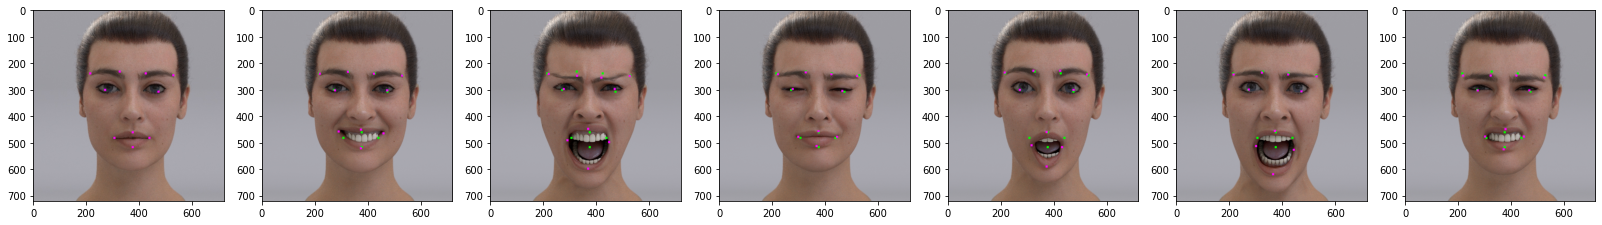

In [21]:
# compare ref to expr lmks
display_images(expr_training_data[0], lmks=sub_expr_lmks_pos, ref_lmks=sub_expr_lmks_pos[0], lmk_size=9)

# Train Norm-Reference Model

In [22]:
# train ref model
ref_vector = sub_ref_lmks_pos[0]
print("ref_vector", np.shape(ref_vector))

ref_vector (10, 2)


In [23]:
# train tuning vectors
tun_vectors = sub_expr_lmks_pos - np.repeat(np.expand_dims(ref_vector, axis=0), len(sub_expr_lmks_pos), axis=0)
print("shape tun_vectors", np.shape(tun_vectors))

shape tun_vectors (7, 10, 2)


In [28]:
# compute projections
def predict_NR(input, ref_vector, tun_vectors, nu=1, verbose=False):
    projections = []

    # normalize by norm of each landmarks
    norm_t = np.linalg.norm(tun_vectors, axis=2)

    # for each images
    for i in range(len(input)):
        # compute relative vector (difference)
        diff = input[i] - ref_vector
        proj = []
        # for each category
        for j in range(len(tun_vectors)):
            proj_length = 0
            # for each landmarks
            for k in range(len(ref_vector)):
                if norm_t[j, k] != 0.0:
                    f = np.dot(diff[k], tun_vectors[j, k]) / norm_t[j, k]
                    f = np.power(f, nu)
                else:
                    f = 0
                proj_length += f
            # ReLu activation
            if proj_length < 0:
                proj_length = 0
            proj.append(proj_length)
        projections.append(proj)

    projections = np.array(projections)

    if verbose:
        print("projections", np.shape(projections))
        print(projections)

    return np.argmax(projections, axis=1)

In [29]:
preds = predict_NR(sub_expr_lmks_pos, ref_vector, tun_vectors, nu=config['nu'], verbose=True)
print("shape preds", np.shape(preds))
print(preds)

projections [[  0.      0.      0.      0.      0.      0.      0.   ]
 [  0.     89.615  26.457  74.297   0.      0.     83.679]
 [  0.    116.991 190.057  45.776  84.169 173.777 141.038]
 [  0.     46.029  37.742  65.889   0.     15.331  45.922]
 [  0.     12.508 100.135   0.    175.957 127.256   8.531]
 [  0.     59.339 185.253   0.    166.474 205.952  81.764]
 [  0.     75.492  65.08   71.266   0.     53.949  90.358]]
[[  0.      0.      0.      0.      0.      0.      0.   ]
 [  0.     89.615  26.457  74.297   0.      0.     83.679]
 [  0.    116.991 190.057  45.776  84.169 173.777 141.038]
 [  0.     46.029  37.742  65.889   0.     15.331  45.922]
 [  0.     12.508 100.135   0.    175.957 127.256   8.531]
 [  0.     59.339 185.253   0.    166.474 205.952  81.764]
 [  0.     75.492  65.08   71.266   0.     53.949  90.358]]
shape preds (7,)
[0 1 2 3 4 5 6]


## TEST model on BFS

In [57]:
test_data = load_data(config, train=False, get_raw=True)
test_data[0] = np.array(test_data[0]).astype(int)

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 105/105 [00:00<00:00, 106.51it/s]


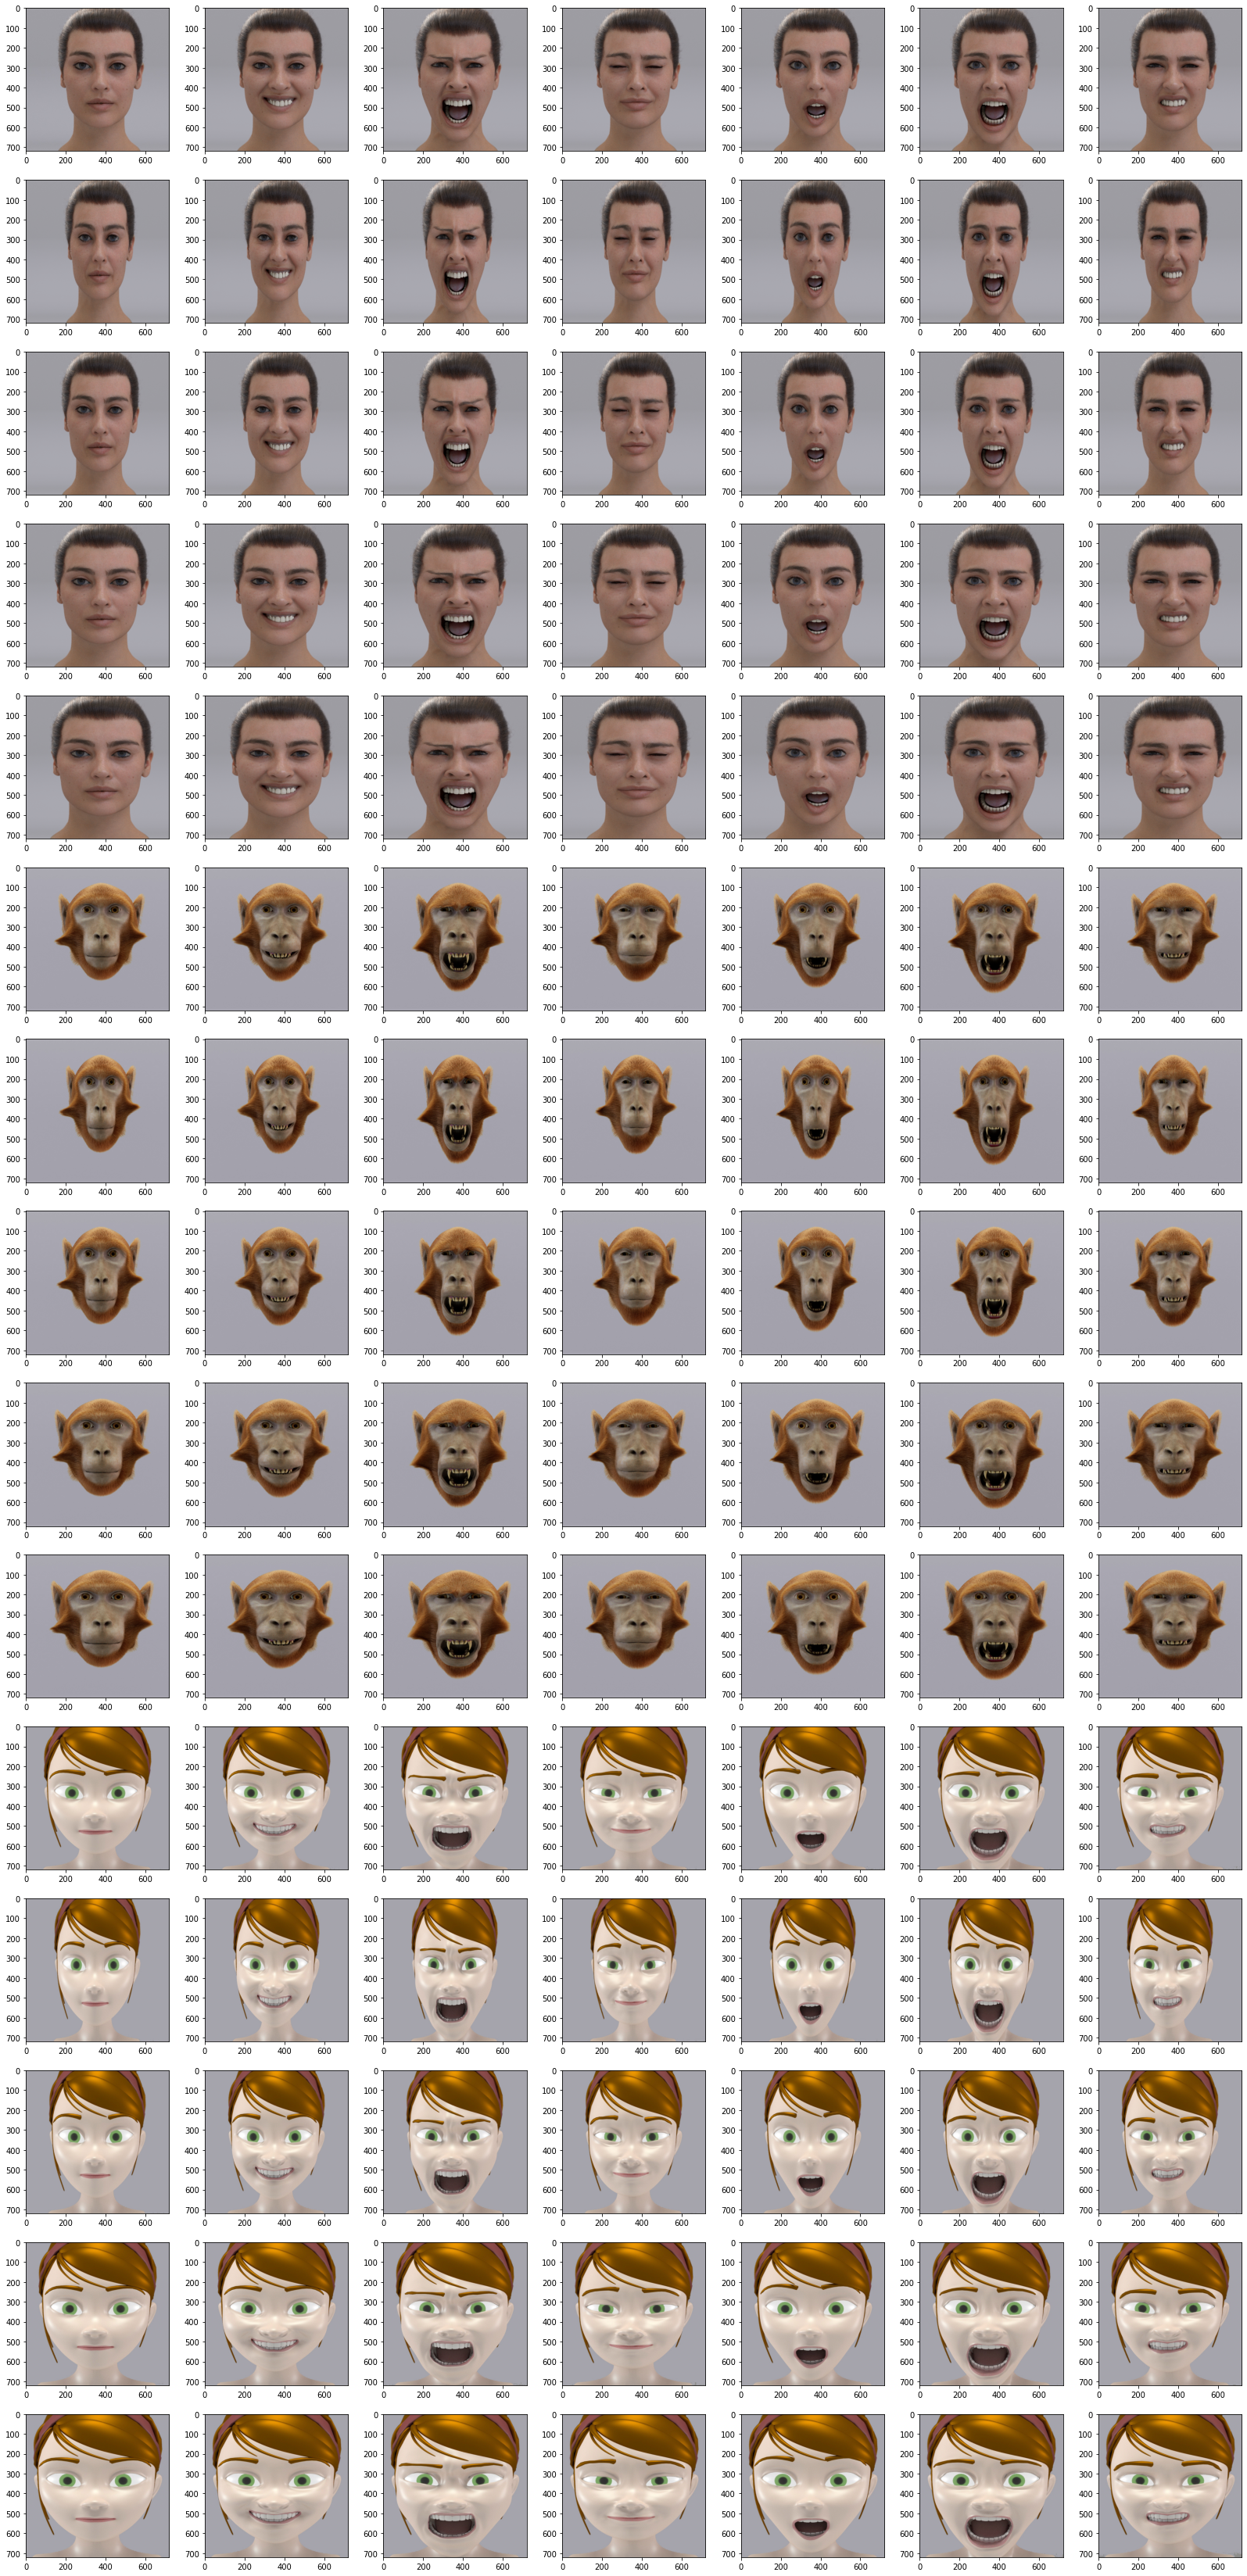

In [58]:
display_images(test_data[0])

In [59]:
# predict lmks on test_data
test_lmks_pos = predict_lmks(test_data[0])

 98%|█████████▊| 103/105 [01:24<00:01,  1.24it/s]/Users/michaelstettler/miniforge3/envs/env_tf/lib/python3.10/site-packages/face_alignment/api.py:144: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")
 99%|█████████▉| 104/105 [01:24<00:00,  1.32it/s]

103 no face detected


100%|██████████| 105/105 [01:25<00:00,  1.23it/s]


In [60]:
print("shape test_lmks_pos", np.shape(test_lmks_pos))
sub_test_lmks_pos = test_lmks_pos[:, sub_idx, :]
print("shape sub_test_lmks_pos", np.shape(sub_test_lmks_pos))
nr_test_preds = predict_NR(sub_test_lmks_pos, ref_vector, tun_vectors, nu=config['nu'])

shape test_lmks_pos (105, 68, 2)
shape sub_test_lmks_pos (105, 10, 2)


In [61]:
corrects = [1 for i in range(len(nr_test_preds)) if nr_test_preds[i] == test_data[1][i]]
n_corrects = np.sum(corrects)
accuracy = n_corrects / len(nr_test_preds)
print("accuracy:", accuracy)

accuracy: 0.3333333333333333


In [62]:
hum_corrects = [1 for p, pred in enumerate(nr_test_preds[:35]) if pred == test_data[1][p]]
n_hum_corrects = np.sum(hum_corrects)
hum_accuracy = n_hum_corrects / len(nr_test_preds[:35])
print("hum_accuracy:", hum_accuracy)

hum_accuracy: 0.6285714285714286


In [63]:
monk_corrects = [1 for p, pred in enumerate(nr_test_preds[35:70]) if pred == test_data[1][p + 35]]
n_monk_corrects = np.sum(monk_corrects)
monk_accuracy = n_monk_corrects / len(nr_test_preds[35:70])
print("monk_accuracy:", monk_accuracy)

monk_accuracy: 0.22857142857142856


In [64]:
mery_corrects = [1 for p, pred in enumerate(nr_test_preds[70:]) if pred == test_data[1][p + 70]]
n_mery_corrects = np.sum(mery_corrects)
mery_accuracy = n_mery_corrects / len(nr_test_preds[70:])
print("mery_accuracy:", mery_accuracy)

mery_accuracy: 0.14285714285714285
